In [1]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

## Put books & summaries in dataframe

In [2]:
# Function to read text from a file
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Path to the folders containing book and summary text files
books_folder = 'D:\Gethub\SummaryFlow\All_novels_textfiles'
summaries_folder = 'D:\Gethub\SummaryFlow\All_summaries_textfiles'

# List all files in each folder
books_files = os.listdir(books_folder)
summaries_files = os.listdir(summaries_folder)

# Initialize lists to store book titles, book text, and summary text
book_titles = []
book_texts = []
summary_texts = []

# Iterate over each book file
for book_file in books_files:
    # Check if there exists a corresponding summary file
    summary_file = os.path.join(summaries_folder, book_file)
    if os.path.isfile(summary_file):
        # Read book text
        book_text = read_text_file(os.path.join(books_folder, book_file))
        # Read summary text
        summary_text = read_text_file(summary_file)
        # Append data to lists
        book_titles.append(os.path.splitext(book_file)[0])
        book_texts.append(book_text)
        summary_texts.append(summary_text)

# Create a DataFrame
data = {
    'Title': book_titles,
    'Book': book_texts,
    'Summary': summary_texts
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# Optionally, you can save the DataFrame to a Excel file
#df.to_excel('books_dataset.xlsx', index=False)


                      Title  \
0  A Canticle for Leibowitz   
1         A Christmas Carol   
2        A Clockwork Orange   
3        A Farewell to Arms   
4      A Fire Upon the Deep   

                                                Book  \
0  A CANTICLE FOR LEIBOWITZ  \n\nWalter M. Miller...   
1  IN PROSE \n\nBEING \n\n                       ...   
2  Anthony Burgess\n\nThe Restored Edition\n\nEdi...   
3  A FAREWELL\n\nVtf 'it\n\nERNEST HEXi\n\n*~~-\n...   
4  Authors and Critics Rave About A Fire Upon the...   

                                             Summary  
0   A Canticle for Leibowitz opens 600 years afte...  
1   Dickens divides the book into five chapters, ...  
2   Alex, a teenager living in near-future Englan...  
3   The novel is divided into five books. In the ...  
4   The novel posits that space around the Milky ...  


In [3]:
len(df)

203

## Split books into chapters

In [ ]:
# Split book into chapters and store them in a list
import nltk
from nltk.tokenize import sent_tokenize

chapters = []
for _ in range(len(df)):
    book_sentences = sent_tokenize(df.Book.values)
    chapters.append(book_sentences)

In [ ]:
# Create book and summary lists
sentences = df.Book.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.Summary.values

## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 399834.69B/s]


Tokenize the first sentence:
['[CLS]', 'a', 'can', '##tic', '##le', 'for', 'lei', '##bow', '##itz', 'walter', 'm', '.', 'miller', ',', 'jr', '.', 'contents', 'acknowledge', '##ment', 'part', 'i', 'fiat', 'homo', 'chapter', 'one', 'chapter', 'two', 'chapter', 'three', 'chapter', 'four', 'chapter', 'five', 'chapter', 'six', 'chapter', 'seven', 'chapter', 'eight', 'chapter', 'nine', 'chapter', 'ten', 'chapter', 'eleven', 'part', 'ii', 'fiat', 'lux', 'chapter', 'twelve', 'chapter', 'thirteen', 'chapter', 'fourteen', 'chapter', 'fifteen', 'chapter', 'sixteen', 'chapter', 'seventeen', 'chapter', 'eighteen', 'chapter', 'nineteen', 'chapter', 'twenty', 'chapter', 'twenty', '-', 'one', 'chapter', 'twenty', '-', 'two', 'chapter', 'twenty', '-', 'three', 'part', 'iii', 'fiat', 'vol', '##unt', '##as', 'tu', '##a', 'chapter', 'twenty', '-', 'four', 'chapter', 'twenty', '-', 'five', 'chapter', 'twenty', '-', 'six', 'chapter', 'twenty', '-', 'seven', 'chapter', 'twenty', '-', 'eight', 'chapter', 'twe

## Word encoding

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(word) for word in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (139148 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (39345 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (124882 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (123667 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (282343 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  seq

In [ ]:
# Pad our input tokens
MAX_LEN = 512
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
#input_ids = pad_sequences(input_ids, dtype="long", truncating="post", padding="post")

اي رقم اعلي من الصفر ب 1 و الصفر كما هو

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

## Split data to train, test & validation

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

## Convert data into tensors

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

## Create an iterator with torch DataLoader

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Load the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:11<00:00, 36399404.07B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

## Set model parameters

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

## Train the model

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    #batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation
  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    #batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    #logits = logits.detach().cpu().numpy()
    #label_ids = b_labels.to('cpu').numpy()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5341928047263276


Epoch:  25%|██▌       | 1/4 [06:40<20:01, 400.47s/it]

Validation Accuracy: 0.7820216049382716
Train loss: 0.28573063393104126


Epoch:  50%|█████     | 2/4 [13:20<13:20, 400.19s/it]

Validation Accuracy: 0.820216049382716
Train loss: 0.14156816012314927


Epoch:  75%|███████▌  | 3/4 [20:00<06:40, 400.07s/it]

Validation Accuracy: 0.8248456790123456
Train loss: 0.0655116576486928


Epoch: 100%|██████████| 4/4 [26:40<00:00, 400.07s/it]

Validation Accuracy: 0.8233024691358025


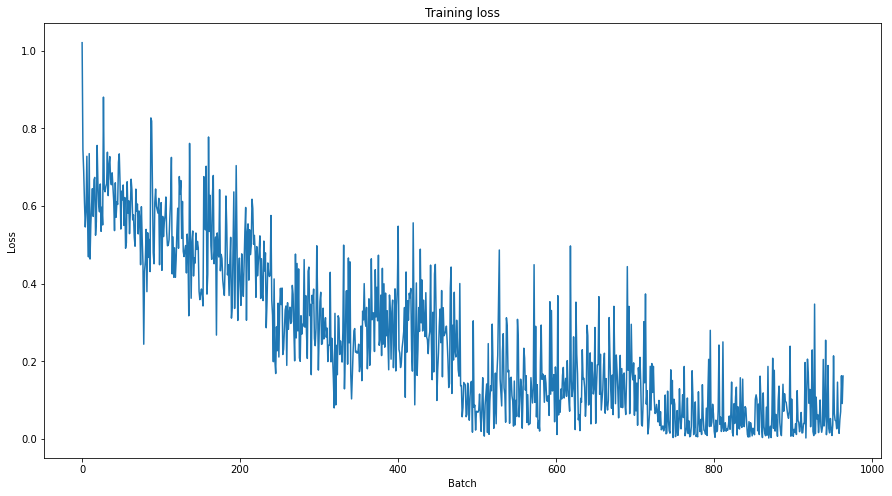

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Testing the model

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  #batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  #logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(b_labels)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [ ]:
matthews_set

[0.049286405809014416,
 -0.17407765595569785,
 0.3316863613133475,
 0.2809003238667948,
 0.49517597397212765,
 0.7410010097502685,
 0.4879500364742666,
 0.47519096331149147,
 0.8333333333333334,
 0.6952687917708212,
 0.7679476477883045,
 0.7006490497453707,
 0.6397114734243627,
 0.7948717948717948,
 0.5897435897435898,
 0.41281272698065485,
 0.0]

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5189767448435781